In [48]:
import sys
sys.path.insert(0, r"C:\users\pairwin\Documents\Github\HelperPI")
#sys.path.insert(0, r'/home/pirwin/Git/HelperPI')
import itertools
import HelperPI
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.formula.api as sts
import numpy as np
import math
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from scipy import interp
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression


%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (11,8)

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999


In [2]:
helper = HelperPI.Helper()

INFO:root:Initializing...


In [254]:
#base, dtypesdf = helper.readData(sql)
base = pd.read_csv(r'C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\tab_model_linear.csv', parse_dates=['DATE_VALUE'])
#base = pd.read_csv(r'/home/pirwin/Git/IPy_Notebooks/SQL/tab_model.csv',parse_dates=['DATE_VALUE'])
base['DAYS_BTW_PURCH'] = base['DAYS_AS_CUSTOMER']/base['TOTAL_TRANSACTIONS']
base['AOS'] = base['TOTAL_SPEND'] / base['TOTAL_TRANSACTIONS']

#dtypes = helper.getDtypes(base)
base.describe()

,MEDHINC_CY,MEDAGE_CY,CLOSEST_BP,CLOSEST_CAB,MALES_IN_HOUSHOLD,FEMALES_IN_HOUSHOLD,REWARDS_CUSTOMER,DAYS_AS_CUSTOMER,TOTAL_TRANSACTIONS,REW_TRANSACTIONS,TOTAL_SPEND,DAYS_SINCE_PURCHASE,TARGET_VALUE15,TARGET_PURCH_NEXT15,DAYS_BTW_PURCH,AOS
count,95933.000000,95933.000000,100000.000000,97092.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000
mean,59166.269261,39.812244,28.442630,114.039020,0.935750,0.372470,0.836510,2537.465300,50.174240,41.452060,3975.802851,297.036980,122.778504,1.0,177.809767,95.581446
std,22138.621342,5.634713,39.506951,142.091088,0.623783,0.539128,0.369814,1279.937874,106.272737,97.976955,8232.023656,543.264772,199.517317,0.0,282.396549,74.995404
min,0.000000,0.000000,0.000000,0.350000,0.000000,0.000000,0.000000,16.000000,1.000000,0.000000,0.790000,9.000000,0.010000,1.0,0.511770,0.790000
25%,42696.000000,36.000000,8.180000,29.300000,1.000000,0.000000,1.000000,1345.000000,8.000000,3.000000,640.155000,38.000000,30.000000,1.0,44.836811,53.851392
50%,54817.000000,40.000000,16.850000,68.660000,1.000000,0.000000,1.000000,2917.000000,23.000000,15.000000,1931.725000,102.000000,66.970000,1.0,90.600000,79.503736
75%,70164.000000,43.000000,36.510000,140.650000,1.000000,1.000000,1.000000,3747.000000,56.000000,46.000000,4911.990000,279.000000,139.990000,1.0,190.876838,115.951250
max,200001.000000,76.000000,2423.890000,5034.100000,18.000000,5.000000,1.000000,3938.000000,7689.000000,7441.000000,939186.990000,3917.000000,8992.970000,1.0,3917.000000,3485.336667


In [255]:
collist = ['MEDHINC_CY','MEDAGE_CY','CLOSEST_BP','MALES_IN_HOUSHOLD','FEMALES_IN_HOUSHOLD','REWARDS_CUSTOMER',
          'DAYS_AS_CUSTOMER','REW_TRANSACTIONS','TOTAL_SPEND','DAYS_SINCE_PURCHASE', 'TOTAL_TRANSACTIONS',
          'DAYS_BTW_PURCH','AOS']
X = base[collist]
y = base['TARGET_VALUE15']

In [256]:
missing_df = X.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / X.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.01]

,column_name,missing_count,missing_ratio
0,MEDHINC_CY,4067,0.04067
1,MEDAGE_CY,4067,0.04067


MEDHINC_CY Coef: 0.01  pval:  0.0001
MEDAGE_CY Coef: 0.01  pval:  0.0005
CLOSEST_BP Coef: 0.02  pval:  0.0000
MALES_IN_HOUSHOLD Coef: 0.03  pval:  0.0000
FEMALES_IN_HOUSHOLD Coef: -0.00  pval:  0.2755
REWARDS_CUSTOMER Coef: 0.07  pval:  0.0000
DAYS_AS_CUSTOMER Coef: 0.02  pval:  0.0000
REW_TRANSACTIONS Coef: 0.03  pval:  0.0000
TOTAL_SPEND Coef: 0.17  pval:  0.0000
DAYS_SINCE_PURCHASE Coef: -0.03  pval:  0.0000
TOTAL_TRANSACTIONS Coef: 0.04  pval:  0.0000
DAYS_BTW_PURCH Coef: -0.05  pval:  0.0000
AOS Coef: 0.26  pval:  0.0000


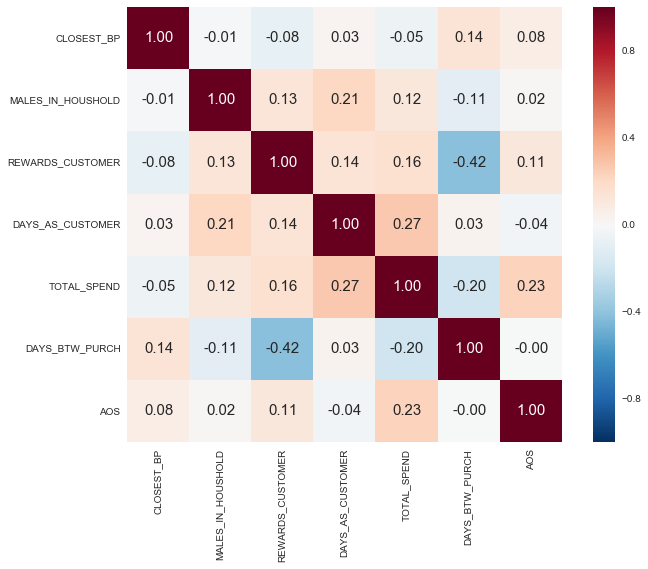

In [257]:
imr = Imputer(missing_values='NaN',strategy='median',axis=0)
imr = imr.fit(X)
imputed_data = pd.DataFrame(imr.transform(X.values), columns = collist)

for var in collist:
    coef, pval = stats.pointbiserialr(imputed_data[var].as_matrix(), y.as_matrix())
    
    print(var + ' Coef: %.2f  pval:  %.4f' % (coef, pval))


collist2 = ['CLOSEST_BP','MALES_IN_HOUSHOLD','REWARDS_CUSTOMER',
          'DAYS_AS_CUSTOMER','TOTAL_SPEND','DAYS_BTW_PURCH','AOS']

imputed_data2 = imputed_data[collist2]
    
corr = imputed_data2.corr()


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, 
            cbar=True,
            annot=True,
            square=True,
            fmt='.2f',
            annot_kws={'size':15},
            yticklabels=collist2,
            xticklabels=collist2)
sns.plt.show()

In [258]:
train_X, test_X, train_y, test_y = helper.splitData2(imputed_data2, y, 0.2)

train_X, val_X, train_y, val_y = helper.splitData2(train_X, train_y, 0.2)

mean = np.mean(train_y)
std = np.std(train_y)

#throw out outliers
a = train_y < mean+std*2
b = train_y > mean-std*2
mask = np.logical_and(a, b)

train_y2 = train_y[mask]
train_X2 = np.array(train_X.values).transpose()[:,mask].transpose()

train_X = pd.DataFrame(train_X, columns=collist2)
val_X = pd.DataFrame(val_X, columns=collist2)
test_X = pd.DataFrame(test_X, columns=collist2)

In [259]:
stdsc = StandardScaler()

stdsc.fit(train_X2)
train_X_std = stdsc.transform(train_X2)
val_X_std = stdsc.transform(val_X)
test_X_std = stdsc.transform(test_X)


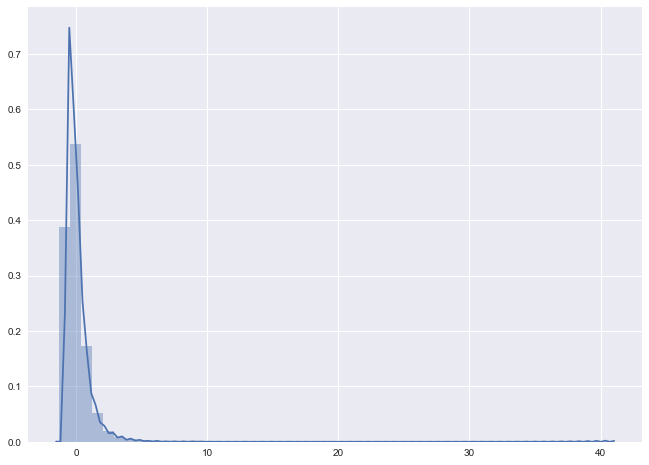

In [262]:
ty = pd.DataFrame(list(train_y2), columns=['train_y'])
tdat = pd.DataFrame(train_X_std, columns = collist2)
tdat['TRAIN_Y2'] = list(train_y2)
tdat

#sns.pairplot(tdat,
#              hue=None,
#              kind='reg')
#sns.plt.show()

sns.distplot(train_X_std[:,6],kde=True)

del tdat, ty

In [263]:
print(val_y.shape, val_X_std.shape)
print(test_y.shape, test_X_std.shape)

(16000,) (16000, 7)
(20000,) (20000, 7)


Coefficients: 
 [  2.95808468   0.83411817   3.79296425   1.31175385   4.07470396
  -3.71604096  22.01022732]
Mean squared error Val: 33044.32
Mean squared error Test: 39527.15
Variance score Val: 0.04
Variance score Test: 0.04


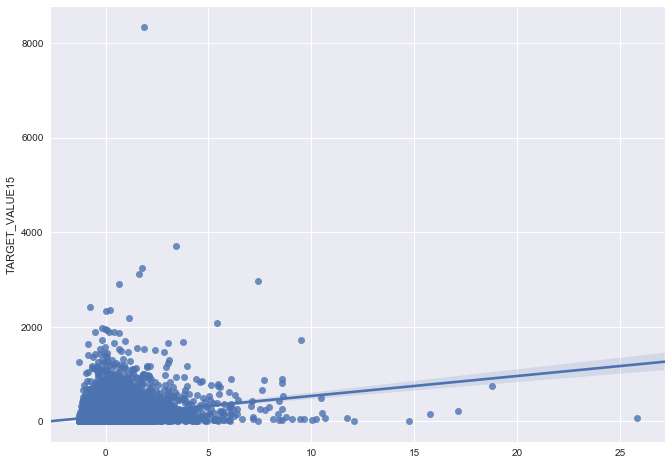

In [279]:
regr = LinearRegression()
regr.fit(train_X_std, train_y2)

print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error Val: %.2f"
      % mean_squared_error(val_y, regr.predict(val_X_std)))
print("Mean squared error Test: %.2f"
      % mean_squared_error(test_y, regr.predict(test_X_std)))
# Explained variance score: 1 is perfect prediction
print('Variance score Val: %.2f' % r2_score(val_y, regr.predict(val_X_std)))
print('Variance score Test: %.2f' % r2_score(test_y, regr.predict(test_X_std)))

# plt.figure()
# #plt.scatter(regr.predict(train_X_std), regr.predict(train_X_std) - train_y2, c='b', s=40, alpha=0.5)
# plt.scatter(regr.predict(val_X_std), regr.predict(val_X_std) - val_y, c='g', s=40, alpha=0.5)
# #plt.scatter(regr.predict(test_X_std), regr.predict(test_X_std) - test_y, c='r', s=40, alpha=0.5)
# plt.hlines(y = 0, xmin=0, xmax=1500)
# plt.ylabel('Residuals')
# plt.title('Residual Plot')
# plt.show()

sns.regplot(val_X_std[:,6], val_y)

In [222]:
#max_depth = 4
#min_child_weight = 0
#colsample_bytree = 1.0
#subsample= 0.7
#gamma = 0.05

param_test1 = {
    'n_estimators':[10,100,300,500, 1000]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(learning_rate=0.1,
                                                     objective='reg:linear',
                                                     max_depth=4,
                                                     n_estimators=100,
                                                     subsample=0.7,
                                                     colsample_bytree=1.0,
                                                     gamma=0.05
                                                     ),
     param_grid = param_test1, scoring='r2', iid=False, cv=5)

gsearch1.fit(train_X_std, train_y2)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.07041, std: 0.00562, params: {'n_estimators': 10},
  mean: 0.09002, std: 0.00591, params: {'n_estimators': 100},
  mean: 0.08578, std: 0.00571, params: {'n_estimators': 300},
  mean: 0.07976, std: 0.00549, params: {'n_estimators': 500},
  mean: 0.06582, std: 0.00528, params: {'n_estimators': 1000}],
 {'n_estimators': 100},
 0.090016048762597431)

In [241]:
#max_delta_step = 1
#max_depth = 2
#min_child_weight = 4
#gamma = 0.1
#subsample = 0.9
#colsample_bytree = 1.0
#reg_alpha = 1

tuned_model = xgb.XGBRegressor(learning_rate=0.01,
                                objective='reg:linear',
                                max_depth=4,
                                n_estimators=2000,
                                subsample=0.7,
                                colsample_bytree=1.0,
                                gamma=0.05)
xgbmodel = tuned_model.fit(train_X_std, train_y2, 
                 eval_set=[(train_X_std, train_y2), (val_X_std, val_y), (test_X_std, test_y)], 
                 eval_metric='rmse',
                 early_stopping_rounds=50,                 
                 verbose=True)

[0]	validation_0-rmse:137.075	validation_1-rmse:219.359	validation_2-rmse:236.582
Multiple eval metrics have been passed: 'validation_2-rmse' will be used for early stopping.

Will train until validation_2-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:136.339	validation_1-rmse:218.78	validation_2-rmse:236.02
[2]	validation_0-rmse:135.612	validation_1-rmse:218.209	validation_2-rmse:235.465
[3]	validation_0-rmse:134.895	validation_1-rmse:217.644	validation_2-rmse:234.918
[4]	validation_0-rmse:134.19	validation_1-rmse:217.09	validation_2-rmse:234.38
[5]	validation_0-rmse:133.491	validation_1-rmse:216.541	validation_2-rmse:233.848
[6]	validation_0-rmse:132.806	validation_1-rmse:216.004	validation_2-rmse:233.326
[7]	validation_0-rmse:132.132	validation_1-rmse:215.474	validation_2-rmse:232.814
[8]	validation_0-rmse:131.464	validation_1-rmse:214.952	validation_2-rmse:232.307
[9]	validation_0-rmse:130.806	validation_1-rmse:214.435	validation_2-rmse:231.807
[10]	validation_0-rmse:130

[98]	validation_0-rmse:100.135	validation_1-rmse:189.915	validation_2-rmse:207.919
[99]	validation_0-rmse:99.993	validation_1-rmse:189.79	validation_2-rmse:207.795
[100]	validation_0-rmse:99.8521	validation_1-rmse:189.665	validation_2-rmse:207.672
[101]	validation_0-rmse:99.7153	validation_1-rmse:189.545	validation_2-rmse:207.552
[102]	validation_0-rmse:99.5787	validation_1-rmse:189.424	validation_2-rmse:207.431
[103]	validation_0-rmse:99.446	validation_1-rmse:189.307	validation_2-rmse:207.316
[104]	validation_0-rmse:99.3152	validation_1-rmse:189.188	validation_2-rmse:207.199
[105]	validation_0-rmse:99.1873	validation_1-rmse:189.074	validation_2-rmse:207.086
[106]	validation_0-rmse:99.061	validation_1-rmse:188.959	validation_2-rmse:206.972
[107]	validation_0-rmse:98.9376	validation_1-rmse:188.842	validation_2-rmse:206.861
[108]	validation_0-rmse:98.815	validation_1-rmse:188.73	validation_2-rmse:206.75
[109]	validation_0-rmse:98.6957	validation_1-rmse:188.622	validation_2-rmse:206.641
[

[196]	validation_0-rmse:93.5902	validation_1-rmse:183.292	validation_2-rmse:201.264
[197]	validation_0-rmse:93.5674	validation_1-rmse:183.261	validation_2-rmse:201.232
[198]	validation_0-rmse:93.5444	validation_1-rmse:183.231	validation_2-rmse:201.2
[199]	validation_0-rmse:93.5217	validation_1-rmse:183.199	validation_2-rmse:201.169
[200]	validation_0-rmse:93.5001	validation_1-rmse:183.171	validation_2-rmse:201.139
[201]	validation_0-rmse:93.479	validation_1-rmse:183.142	validation_2-rmse:201.11
[202]	validation_0-rmse:93.4576	validation_1-rmse:183.113	validation_2-rmse:201.08
[203]	validation_0-rmse:93.4359	validation_1-rmse:183.085	validation_2-rmse:201.05
[204]	validation_0-rmse:93.4158	validation_1-rmse:183.057	validation_2-rmse:201.022
[205]	validation_0-rmse:93.3954	validation_1-rmse:183.028	validation_2-rmse:200.992
[206]	validation_0-rmse:93.3753	validation_1-rmse:182.999	validation_2-rmse:200.963
[207]	validation_0-rmse:93.3554	validation_1-rmse:182.969	validation_2-rmse:200.93

[294]	validation_0-rmse:92.4736	validation_1-rmse:181.542	validation_2-rmse:199.432
[295]	validation_0-rmse:92.4693	validation_1-rmse:181.534	validation_2-rmse:199.423
[296]	validation_0-rmse:92.4649	validation_1-rmse:181.525	validation_2-rmse:199.414
[297]	validation_0-rmse:92.4602	validation_1-rmse:181.515	validation_2-rmse:199.402
[298]	validation_0-rmse:92.4558	validation_1-rmse:181.504	validation_2-rmse:199.389
[299]	validation_0-rmse:92.4515	validation_1-rmse:181.494	validation_2-rmse:199.38
[300]	validation_0-rmse:92.4472	validation_1-rmse:181.485	validation_2-rmse:199.367
[301]	validation_0-rmse:92.4427	validation_1-rmse:181.479	validation_2-rmse:199.356
[302]	validation_0-rmse:92.4382	validation_1-rmse:181.469	validation_2-rmse:199.345
[303]	validation_0-rmse:92.4336	validation_1-rmse:181.459	validation_2-rmse:199.335
[304]	validation_0-rmse:92.4299	validation_1-rmse:181.451	validation_2-rmse:199.328
[305]	validation_0-rmse:92.4261	validation_1-rmse:181.443	validation_2-rmse:1

[392]	validation_0-rmse:92.1798	validation_1-rmse:180.946	validation_2-rmse:198.817
[393]	validation_0-rmse:92.1785	validation_1-rmse:180.943	validation_2-rmse:198.814
[394]	validation_0-rmse:92.1768	validation_1-rmse:180.942	validation_2-rmse:198.812
[395]	validation_0-rmse:92.1744	validation_1-rmse:180.938	validation_2-rmse:198.808
[396]	validation_0-rmse:92.1723	validation_1-rmse:180.934	validation_2-rmse:198.804
[397]	validation_0-rmse:92.1701	validation_1-rmse:180.93	validation_2-rmse:198.8
[398]	validation_0-rmse:92.168	validation_1-rmse:180.924	validation_2-rmse:198.797
[399]	validation_0-rmse:92.1656	validation_1-rmse:180.922	validation_2-rmse:198.793
[400]	validation_0-rmse:92.1638	validation_1-rmse:180.917	validation_2-rmse:198.79
[401]	validation_0-rmse:92.1614	validation_1-rmse:180.914	validation_2-rmse:198.786
[402]	validation_0-rmse:92.1591	validation_1-rmse:180.909	validation_2-rmse:198.783
[403]	validation_0-rmse:92.1573	validation_1-rmse:180.907	validation_2-rmse:198.7

[491]	validation_0-rmse:92.0178	validation_1-rmse:180.695	validation_2-rmse:198.573
[492]	validation_0-rmse:92.0164	validation_1-rmse:180.694	validation_2-rmse:198.571
[493]	validation_0-rmse:92.0146	validation_1-rmse:180.691	validation_2-rmse:198.568
[494]	validation_0-rmse:92.0133	validation_1-rmse:180.688	validation_2-rmse:198.567
[495]	validation_0-rmse:92.0122	validation_1-rmse:180.686	validation_2-rmse:198.563
[496]	validation_0-rmse:92.0118	validation_1-rmse:180.686	validation_2-rmse:198.562
[497]	validation_0-rmse:92.01	validation_1-rmse:180.685	validation_2-rmse:198.562
[498]	validation_0-rmse:92.0086	validation_1-rmse:180.685	validation_2-rmse:198.561
[499]	validation_0-rmse:92.0068	validation_1-rmse:180.681	validation_2-rmse:198.559
[500]	validation_0-rmse:92.0056	validation_1-rmse:180.68	validation_2-rmse:198.559
[501]	validation_0-rmse:92.004	validation_1-rmse:180.673	validation_2-rmse:198.554
[502]	validation_0-rmse:92.0031	validation_1-rmse:180.671	validation_2-rmse:198.

[589]	validation_0-rmse:91.8956	validation_1-rmse:180.587	validation_2-rmse:198.475
[590]	validation_0-rmse:91.8951	validation_1-rmse:180.586	validation_2-rmse:198.474
[591]	validation_0-rmse:91.8933	validation_1-rmse:180.582	validation_2-rmse:198.475
[592]	validation_0-rmse:91.8924	validation_1-rmse:180.581	validation_2-rmse:198.474
[593]	validation_0-rmse:91.8914	validation_1-rmse:180.579	validation_2-rmse:198.473
[594]	validation_0-rmse:91.8899	validation_1-rmse:180.577	validation_2-rmse:198.471
[595]	validation_0-rmse:91.8892	validation_1-rmse:180.577	validation_2-rmse:198.47
[596]	validation_0-rmse:91.8888	validation_1-rmse:180.576	validation_2-rmse:198.473
[597]	validation_0-rmse:91.8878	validation_1-rmse:180.576	validation_2-rmse:198.474
[598]	validation_0-rmse:91.8861	validation_1-rmse:180.574	validation_2-rmse:198.474
[599]	validation_0-rmse:91.885	validation_1-rmse:180.573	validation_2-rmse:198.472
[600]	validation_0-rmse:91.8832	validation_1-rmse:180.573	validation_2-rmse:19

[687]	validation_0-rmse:91.7874	validation_1-rmse:180.541	validation_2-rmse:198.442
[688]	validation_0-rmse:91.7859	validation_1-rmse:180.54	validation_2-rmse:198.441
[689]	validation_0-rmse:91.7849	validation_1-rmse:180.54	validation_2-rmse:198.441
[690]	validation_0-rmse:91.7839	validation_1-rmse:180.538	validation_2-rmse:198.444
[691]	validation_0-rmse:91.783	validation_1-rmse:180.536	validation_2-rmse:198.443
[692]	validation_0-rmse:91.7812	validation_1-rmse:180.535	validation_2-rmse:198.442
[693]	validation_0-rmse:91.7801	validation_1-rmse:180.536	validation_2-rmse:198.443
[694]	validation_0-rmse:91.7797	validation_1-rmse:180.536	validation_2-rmse:198.444
[695]	validation_0-rmse:91.7781	validation_1-rmse:180.535	validation_2-rmse:198.44
[696]	validation_0-rmse:91.7756	validation_1-rmse:180.534	validation_2-rmse:198.44
[697]	validation_0-rmse:91.7746	validation_1-rmse:180.535	validation_2-rmse:198.44
[698]	validation_0-rmse:91.7726	validation_1-rmse:180.536	validation_2-rmse:198.44

[785]	validation_0-rmse:91.6759	validation_1-rmse:180.526	validation_2-rmse:198.435
[786]	validation_0-rmse:91.6747	validation_1-rmse:180.527	validation_2-rmse:198.436
[787]	validation_0-rmse:91.6727	validation_1-rmse:180.528	validation_2-rmse:198.436
[788]	validation_0-rmse:91.6716	validation_1-rmse:180.528	validation_2-rmse:198.434
[789]	validation_0-rmse:91.6713	validation_1-rmse:180.528	validation_2-rmse:198.436
[790]	validation_0-rmse:91.6703	validation_1-rmse:180.528	validation_2-rmse:198.435
[791]	validation_0-rmse:91.669	validation_1-rmse:180.528	validation_2-rmse:198.434
[792]	validation_0-rmse:91.6679	validation_1-rmse:180.529	validation_2-rmse:198.435
[793]	validation_0-rmse:91.667	validation_1-rmse:180.528	validation_2-rmse:198.435
[794]	validation_0-rmse:91.6657	validation_1-rmse:180.528	validation_2-rmse:198.434
[795]	validation_0-rmse:91.6646	validation_1-rmse:180.528	validation_2-rmse:198.433
[796]	validation_0-rmse:91.6635	validation_1-rmse:180.527	validation_2-rmse:19

Mean squared error Val: 32590.05
Mean squared error Test: 39371.94
Variance score Val: 0.05
Variance score Test: 0.04


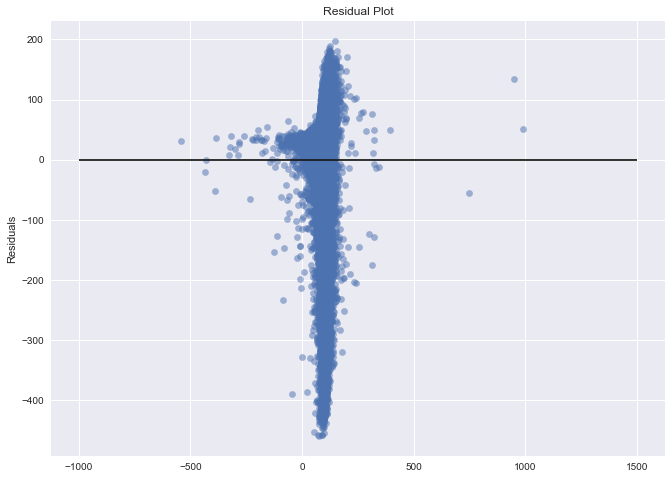

In [243]:
#print('Coefficients: \n', xgbmodel.coef_)
# The mean squared error
print("Mean squared error Val: %.2f"
      % mean_squared_error(val_y, xgbmodel.predict(val_X_std)))
print("Mean squared error Test: %.2f"
      % mean_squared_error(test_y, xgbmodel.predict(test_X_std)))
# Explained variance score: 1 is perfect prediction
print('Variance score Val: %.2f' % r2_score(val_y, xgbmodel.predict(val_X_std)))
print('Variance score Test: %.2f' % r2_score(test_y, xgbmodel.predict(test_X_std)))

plt.figure()
plt.scatter(regr.predict(train_X_std), xgbmodel.predict(train_X_std) - train_y2, c='b', s=40, alpha=0.5)
#plt.scatter(regr.predict(val_X_std), xgbmodel.predict(val_X_std) - val_y, c='g', s=40, alpha=0.5)
#plt.scatter(regr.predict(test_X_std), xgbmodel.predict(test_X_std) - test_y, c='r', s=40, alpha=0.5)
plt.hlines(y = 0, xmin=-1000, xmax=1500)
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()